# Simple EGFR model

See http://bionetgen.org/index.php/Simple_EGFR_model for details.

In [1]:
%matplotlib inline
from ecell4.prelude import *

In [2]:
citation(16233948)

Blinov ML, Faeder JR, Goldstein B, Hlavacek WS, A network model of early events in epidermal growth factor receptor signaling that accounts for combinatorial complexity. *Bio Systems*, **2-3**(83), 136-51, 2006. [10.1016/j.biosystems.2005.06.014](https://doi.org/10.1016/j.biosystems.2005.06.014). PubMed PMID: [16233948](https://www.ncbi.nlm.nih.gov/pubmed/16233948).

In [3]:
NA = 6.02e23  # Avogadro's number (molecules/mol)
f = 1  # Fraction of the cell to simulate
Vo = f * 1.0e-10  # Extracellular volume=1/cell_density (L)
V = f * 3.0e-12  # Cytoplasmic volume (L)

EGF_init = 20 * 1e-9 * NA * Vo  # Initial amount of ligand (20 nM) converted to copies per cell

# Initial amounts of cellular components (copies per cell)
EGFR_init = f * 1.8e5
Grb2_init = f * 1.5e5
Sos1_init = f * 6.2e4

# Rate constants
# Divide by NA*V to convert bimolecular rate constants
# from /M/sec to /(molecule/cell)/sec
kp1 = 9.0e7 / (NA * Vo)  # ligand-monomer binding
km1 = 0.06  # ligand-monomer dissociation
kp2 = 1.0e7 / (NA * V)  # aggregation of bound monomers
km2 = 0.1  # dissociation of bound monomers
kp3 = 0.5  # dimer transphosphorylation
km3 = 4.505  # dimer dephosphorylation
kp4 = 1.5e6 / (NA * V)  # binding of Grb2 to receptor
km4 = 0.05  # dissociation of Grb2 from receptor
kp5 = 1.0e7 / (NA * V)  # binding of Grb2 to Sos1
km5 = 0.06  # dissociation of Grb2 from Sos1
deg = 0.01  # degradation of receptor dimers

In [4]:
with reaction_rules():
  # R1: Ligand-receptor binding
  EGFR(L, CR1) + EGF(R) == EGFR(L^1, CR1).EGF(R^1) | (kp1, km1)
  
  # R2: Receptor-aggregation
  EGFR(L^_, CR1) + EGFR(L^_, CR1) == EGFR(L^_,CR1^1).EGFR(L^_,CR1^1) | (kp2, km2)
  
  # R3: Transphosphorylation of EGFR by RTK
  EGFR(CR1^_, Y1068=U) > EGFR(CR1^_, Y1068=P) | kp3
  
  # R4: Dephosphorylation
  EGFR(Y1068=P) > EGFR(Y1068=U) | km3
  
  # R5: Grb2 binding to pY1068
  EGFR(Y1068=P) + Grb2(SH2) == EGFR(Y1068=P^1).Grb2(SH2^1) | (kp4, km4)
  
  # R6: Grb2 binding to Sos1
  Grb2(SH3) + Sos1(PxxP) == Grb2(SH3^1).Sos1(PxxP^1) | (kp5, km5)
  
  # R7: Receptor dimer internalization/degradation
  (EGF(R^1).EGF(R^2).EGFR(L^1,CR1^3).EGFR(L^2,CR1^3) > ~EmptySet | deg
       | ReactionRule.STRICT | ReactionRule.DESTROY)

m1 = get_model(is_netfree=True, effective=True)

In [5]:
show(m1)


EGFR(L, CR1) + EGF(R) > EGFR(L ^ 1, CR1).EGF(R ^ 1) | 1.495016611295681e-06
EGFR(L ^ 1, CR1).EGF(R ^ 1) > EGFR(L, CR1) + EGF(R) | 0.06
EGFR(L ^ _, CR1) + EGFR(L ^ _, CR1) > EGFR(L ^ _, CR1 ^ 1).EGFR(L ^ _, CR1 ^ 1) | 5.537098560354375e-06
EGFR(L ^ _, CR1 ^ 1).EGFR(L ^ _, CR1 ^ 1) > EGFR(L ^ _, CR1) + EGFR(L ^ _, CR1) | 0.1
EGFR(CR1 ^ _, Y1068=U) > EGFR(CR1 ^ _, Y1068=P) | 0.5
EGFR(Y1068=P) > EGFR(Y1068=U) | 4.505
EGFR(Y1068=P) + Grb2(SH2) > EGFR(Y1068=P ^ 1).Grb2(SH2 ^ 1) | 8.305647840531562e-07
EGFR(Y1068=P ^ 1).Grb2(SH2 ^ 1) > EGFR(Y1068=P) + Grb2(SH2) | 0.05
Grb2(SH3) + Sos1(PxxP) > Grb2(SH3 ^ 1).Sos1(PxxP ^ 1) | 5.537098560354375e-06
Grb2(SH3 ^ 1).Sos1(PxxP ^ 1) > Grb2(SH3) + Sos1(PxxP) | 0.06
EGF(R ^ 1).EGF(R ^ 2).EGFR(L ^ 1, CR1 ^ 3).EGFR(L ^ 2, CR1 ^ 3) >  | 0.01


In [6]:
y0 = {"EGF(R)": EGF_init, "EGFR(L,CR1,Y1068=U)": EGFR_init, "Grb2(SH2,SH3)": Grb2_init, "Sos1(PxxP)": Sos1_init}

In [7]:
m2 = m1.expand([Species(serial) for serial in y0.keys()])

In [8]:
print("{} species and {} reactions were generated.".format(len(m2.list_species()), len(m2.reaction_rules())))

22 species and 86 reactions were generated.


In [9]:
show(m2)

EGFR(CR1,L,Y1068=P^1).Grb2(SH2^1,SH3^2).Sos1(PxxP^2) | {}
EGFR(CR1,L,Y1068=P^1).Grb2(SH2^1,SH3) | {}
EGF(R^1).EGFR(CR1^2,L^1,Y1068=P^3).EGFR(CR1^2,L^4,Y1068=P^5).EGF(R^4).Grb2(SH2^5,SH3^6).Sos1(PxxP^6).Grb2(SH2^3,SH3^7).Sos1(PxxP^7) | {}
EGF(R^1).EGFR(CR1^2,L^1,Y1068=P^3).EGFR(CR1^2,L^4,Y1068=P^5).EGF(R^4).Grb2(SH2^5,SH3).Grb2(SH2^3,SH3^6).Sos1(PxxP^6) | {}
EGF(R^1).EGFR(CR1^2,L^1,Y1068=P^3).EGFR(CR1^2,L^4,Y1068=P^5).EGF(R^4).Grb2(SH2^5,SH3).Grb2(SH2^3,SH3) | {}
EGFR(CR1,L,Y1068=P) | {}
EGF(R^1).EGFR(CR1,L^1,Y1068=P^2).Grb2(SH2^2,SH3^3).Sos1(PxxP^3) | {}
EGF(R^1).EGFR(CR1,L^1,Y1068=P^2).Grb2(SH2^2,SH3) | {}
EGF(R^1).EGFR(CR1^2,L^1,Y1068=P).EGFR(CR1^2,L^3,Y1068=P^4).EGF(R^3).Grb2(SH2^4,SH3^5).Sos1(PxxP^5) | {}
EGF(R^1).EGFR(CR1^2,L^1,Y1068=P).EGFR(CR1^2,L^3,Y1068=P^4).EGF(R^3).Grb2(SH2^4,SH3) | {}
EGF(R^1).EGFR(CR1,L^1,Y1068=P) | {}
EGF(R^1).EGFR(CR1^2,L^1,Y1068=P).EGFR(CR1^2,L^3,Y1068=P).EGF(R^3) | {}
EGF(R^1).EGFR(CR1^2,L^1,Y1068=P^3).EGFR(CR1^2,L^4,Y1068=U).EGF(R^4).Grb2(SH2^3,SH3^5)

In [10]:
ret = run_simulation(120, model=m2, y0=y0)

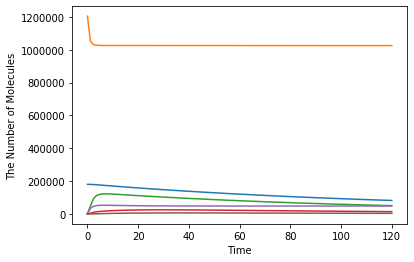

In [11]:
ret.plot(y=[
    "EGFR", "EGF(R)", "EGFR(CR1^_)", "EGFR(Y1068=P^_0)", "Grb2(SH2, SH3^1).Sos1(PxxP^1)",
    "EGFR(Y1068^1).Grb2(SH2^1, SH3^2).Sos1(PxxP^2)"])